In [1]:
import json
import spotipy
import pandas as pd
import matplotlib.pyplot as plt
from spotipy.oauth2 import SpotifyClientCredentials

In [2]:
client_id = '<insert your client_id here>'
client_secret = '<<insert your client_secret here>>'

client_creds_manager = SpotifyClientCredentials(client_id, client_secret)

sp = spotipy.Spotify(client_credentials_manager=client_creds_manager)

In [3]:
playlist_id = '3pVgpGdLt8m5CKv0hBwriF'
results = sp.playlist(playlist_id)

In [4]:
ids = [item['track']['id'] for item in results['tracks']['items']]

In [5]:
tracks = sp.tracks(tracks=ids[:50])['tracks'] + sp.tracks(tracks=ids[50:])['tracks']
audio_features = sp.audio_features(ids)

In [6]:
tracks_df = pd.DataFrame(tracks)
audio_features_df = pd.DataFrame(audio_features)

In [7]:
track_metadata_list = ['artist_name',
                       'album_name',
                       'name',
                       'duration_msid',
                       'release_year',
                       'albumart_url_300']

audio_features_list = ['acousticness', 
                       'danceability', 
                       'energy', 
                       'instrumentalness', 
                       'liveness', 
                       'loudness', 
                       'speechiness', 
                       'tempo', 
                       'valence', 
                       'key']

In [8]:
track_info_df = tracks_df.join(audio_features_df, lsuffix='id', rsuffix='id', how='inner')

# Removing columns with duplicate names
# https://stackoverflow.com/a/40435354
track_info_df = track_info_df.loc[:,~track_info_df.columns.duplicated()]

track_info_df['artist_name'] = track_info_df.apply(lambda row: row.album['artists'][0]['name'], axis=1)
track_info_df['album_name'] = track_info_df.apply(lambda row: row.album['name'], axis=1)
track_info_df['release_year'] = track_info_df.apply(lambda row: row.album['release_date'][:4] if '-' in  row.album['release_date'] else row.album['release_date'], axis=1)
track_info_df['albumart_url_640'] = track_info_df.apply(lambda row: row.album['images'][0]['url'], axis=1)
track_info_df['albumart_url_300'] = track_info_df.apply(lambda row: row.album['images'][1]['url'], axis=1)
track_info_df['albumart_url_64'] = track_info_df.apply(lambda row: row.album['images'][2]['url'], axis=1)

In [9]:
track_info_df.to_csv('track_info.csv')

In [10]:
track_info_filtered_df = track_info_df[track_metadata_list + audio_features_list]

In [11]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

track_info_new = track_info_filtered_df.copy(deep=True)
track_info_new[audio_features_list] = min_max_scaler.fit_transform(track_info_new[audio_features_list])

/home/ka/Installations/miniconda3/envs/ML/lib/python3.5/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [12]:
track_info_new.album_name.unique().tolist()

['Hymn to the Immortal Wind (Anniversary Edition)',
 'You Are There',
 'For My Parents',
 'The Earth Is Not a Cold Dead Place',
 'All of a Sudden I Miss Everyone',
 'Lift Your Skinny Fists Like Antennas to Heaven',
 'Slow Riot for New Zero Kanada',
 'Enjoy Eternal Bliss',
 'Under Summer',
 'Golevka',
 'Beast, Please Be Still',
 'One is Glad to Be of Service',
 'Chapter 1: Had We Known Better',
 'Young Mountain',
 'Ágætis byrjun',
 'F♯ A♯ ∞']

In [13]:
mean_album_features_df = pd.DataFrame(columns=['album_name', 'albumart_url'] + audio_features_list)
mean_album_features_df['albumart_url']=mean_album_features_df['albumart_url'].astype('str')

for tmp_album in track_info_new.album_name.unique().tolist():
    tmp_df = track_info_new[track_info_new['album_name'] == tmp_album]
    tmp_dict = tmp_df[audio_features_list].mean().to_dict()
    tmp_dict['album_name'] = tmp_album
    tmp_dict['albumart_url'] = tmp_df['albumart_url_300'].tolist()[0]
    mean_album_features_df = mean_album_features_df.append(tmp_dict, ignore_index=True)

std_album_features_df = pd.DataFrame(columns=['album_name', 'albumart_url'] + audio_features_list)
std_album_features_df['albumart_url']=std_album_features_df['albumart_url'].astype('str')

for tmp_album in track_info_new.album_name.unique().tolist():
    tmp_df = track_info_new[track_info_new['album_name'] == tmp_album]
    tmp_dict = tmp_df[audio_features_list].std().to_dict()
    tmp_dict['album_name'] = tmp_album
    tmp_dict['albumart_url'] = tmp_df['albumart_url_300'].tolist()[0]
    std_album_features_df = std_album_features_df.append(tmp_dict, ignore_index=True)

In [14]:
mean_album_features_df.head()

,album_name,albumart_url,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key
0,Hymn to the Immortal Wind (Anniversary Edition),https://i.scdn.co/image/ab67616d00001e02fde87f...,0.376694,0.219708,0.381705,0.857697,0.100374,0.661528,0.151059,0.398625,0.323112,0.597403
1,You Are There,https://i.scdn.co/image/ab67616d00001e02b794bc...,0.513100,0.135301,0.180307,0.932262,0.213122,0.490513,0.162216,0.356430,0.163671,0.651515
2,For My Parents,https://i.scdn.co/image/ab67616d00001e02255d7a...,0.474285,0.218857,0.393397,0.862872,0.115780,0.771276,0.131108,0.259501,0.068294,0.763636
3,The Earth Is Not a Cold Dead Place,https://i.scdn.co/image/ab67616d00001e0239539a...,0.139346,0.380319,0.486399,0.851013,0.318182,0.576263,0.112684,0.450816,0.110682,0.345455
4,All of a Sudden I Miss Everyone,https://i.scdn.co/image/ab67616d00001e02db8a78...,0.316722,0.296470,0.593699,0.829488,0.166524,0.768883,0.200935,0.467887,0.088392,0.560606


In [ ]:
import urllib.request

for idx, row in mean_album_features_df.iterrows():
    urllib.request.urlretrieve(row['albumart_url'], filename='albumart/'+row['album_name'].split(' ')[0]+'.jpg')

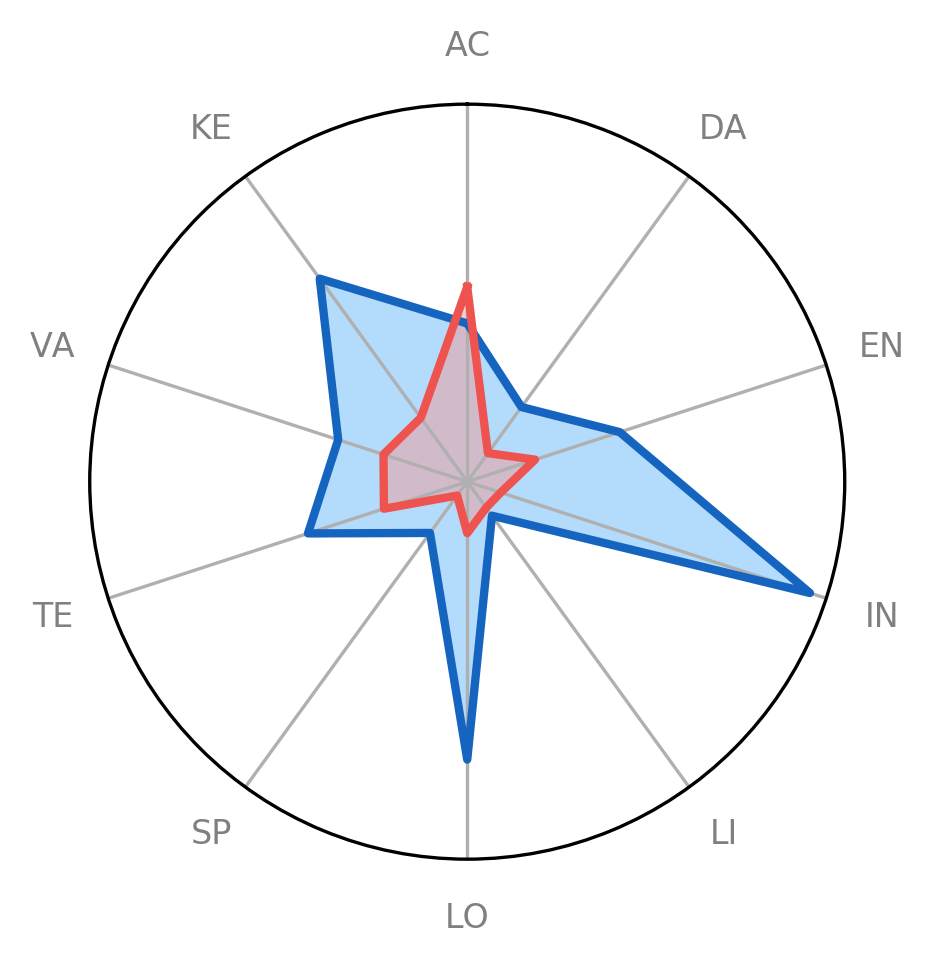

In [16]:
from math import pi
import numpy as np
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def draw_radar_plot(row_idx):
 
    categories=[af[:2].upper() for af in audio_features_list]
    N = len(categories)

    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    ax = plt.subplot(1,1,1, polar=True, )

    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    plt.xticks(angles[:-1], categories, color='grey', size=8)

    ax.set_rlabel_position(0)
    plt.yticks([])

    values_mean=mean_album_features_df.loc[row_idx].drop('album_name').drop('albumart_url').values.flatten().tolist()
    values_mean += values_mean[:1]    
    plt.plot(angles, values_mean, linewidth=2, linestyle='solid', color='#1565c0')
    plt.fill(angles, values_mean, alpha=0.4, color='#42a5f5')
    
    values_std=std_album_features_df.loc[row_idx].drop('album_name').drop('albumart_url').values.flatten().tolist()
    values_std += values_std[:1]    
    plt.plot(angles, values_std, linewidth=2, linestyle='solid', color='#ef5350')
    plt.fill(angles, values_std, alpha=0.5, color='#ef9a9a')

    album_name_abbrv = mean_album_features_df.loc[row_idx]['album_name'].split(' ')[0]
    img = Image.open('albumart/{:s}.jpg'.format(album_name_abbrv))
    width, height = img.size[0], img.size[1]
    img = np.array(img).astype(np.float) / 255.
#     plt.savefig('radarplots/{:s}.png'.format(album_name_abbrv))
    plt.show()
    
my_dpi=300
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
 
 
idx=0
for row_idx in range(idx, idx+1):
    draw_radar_plot(row_idx)